### 시황별 어떤 팩터가 좋은지 확인

In [1]:
from econ_regime.econ_regime import *
from price.macro_info import get_econ_info
from price.price_processing import *
from strategy.factors.momentum import *
from strategy.factors.volatility import *
from strategy.factors.beta import *
from strategy.optimize.cross_sectional import *
from backtest.metric import *

import pandas as pd
import numpy as np
import statsmodels.api as sm
import bs4 as bs
import requests
import datetime as dt
import pickle5 as pickle

### 주식 베타

In [2]:
equity_df = pd.read_csv('../quant/equity_universe.csv', index_col=0)
equity_df.index = pd.to_datetime(equity_df.index)

equity_df = equity_df.loc['2011':,].dropna(axis=1)

benchmark = pd.DataFrame({'SPY': yf.download('SPY', start=equity_df.iloc[0].name, end=equity_df.iloc[-1].name)['Adj Close']})

equity_universe = pd.concat([equity_df, benchmark], axis=1).dropna()

monthly_index = equity_universe.resample('M').last().index
monthly_index = monthly_index[12:]

[*********************100%***********************]  1 of 1 completed


### 시그널

In [4]:
beta_signal = Beta(equity_with_benchmark=equity_universe, benchmark_ticker='SPY').beta()

,A,AAL,AAP,AAPL,ABC,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
2012-01-31,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-02-29,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-03-31,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-04-30,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-05-31,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-09-30,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-10-31,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 투자비중 

In [5]:
beta_ew_weight = Equalizer(signal=beta_signal, rebal_price=equity_df.resample('M').last(), param=12).ew()

factor_portval = calculate_portvals(price_df=equity_universe.loc['2012':,], weight_df=beta_ew_weight, signal_df=beta_signal,long_only=True)
factor_daily_rets = port_rets(factor_portval, cumulative=False)
factor_cum_rets = port_rets(factor_portval, cumulative=True)

factor_daily_rets.to_csv('result/beta_daily_rets.csv')

<AxesSubplot: >

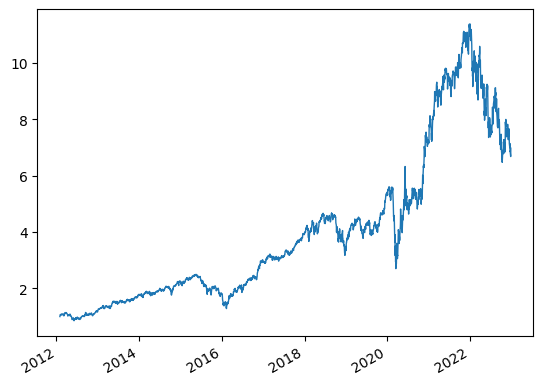

In [6]:
factor_cum_rets.plot(lw=1)

### spy index와 beta20 누적수익률

In [7]:
Metric(portfolio=(1 + benchmark.loc['2012':,].pct_change().fillna(0)).cumprod(), freq='day').print_report()
print()
Metric(portfolio=factor_cum_rets, freq='day').print_report()

Total Returns: 370.13%
CAGR: 12.66%
Annualized Volatility: 17.01%
Skewness: -0.56
Kurtosis: 13.50
Max Drawdown: -33.72%
Max Drawdown Duration: 360.00 days
Annualized Sharp Ratio: 0.51
Annualized Sortino Ratio: 0.87
Annualized Calmar Ratio: 0.38
Annualized VaR: -0.03
Annualized VaR Ratio: 0.02
Annualized CVaR: -0.04
Annualized CVaR Ratio: 0.01
Annualized hit Ratio: 0.55
Annualized GtP Ratio: 0.95

Total Returns: 697.07%
CAGR: 19.79%
Annualized Volatility: 33.32%
Skewness: -0.01
Kurtosis: 7.64
Max Drawdown: -51.82%
Max Drawdown Duration: 540.00 days
Annualized Sharp Ratio: 0.47
Annualized Sortino Ratio: 0.82
Annualized Calmar Ratio: 0.38
Annualized VaR: -0.06
Annualized VaR Ratio: 0.02
Annualized CVaR: -0.08
Annualized CVaR Ratio: 0.01
Annualized hit Ratio: 0.53
Annualized GtP Ratio: 0.99


AxesSubplot(0.125,0.11;0.775x0.77)


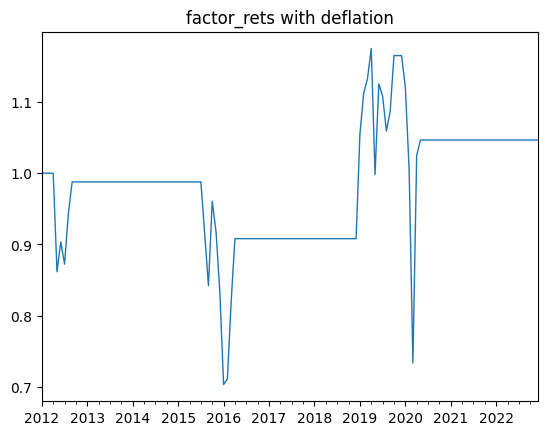

AxesSubplot(0.125,0.11;0.775x0.77)


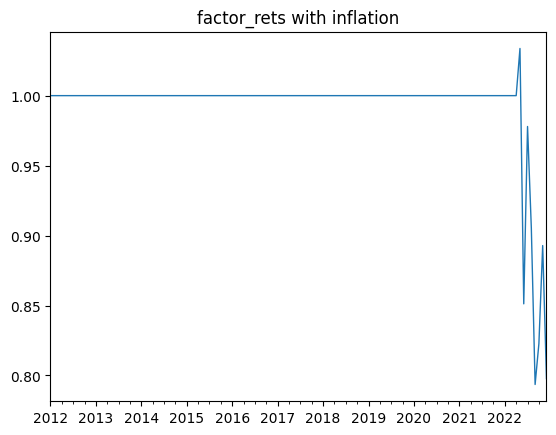

AxesSubplot(0.125,0.11;0.775x0.77)


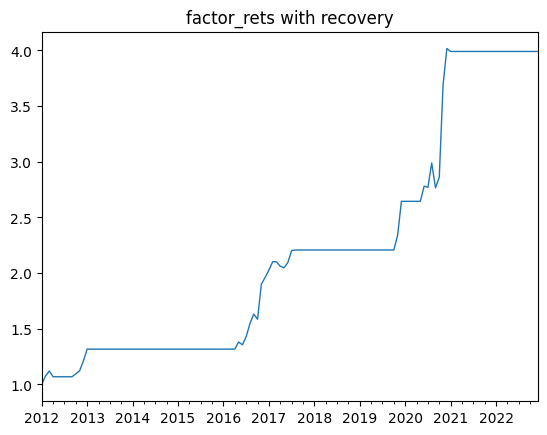

AxesSubplot(0.125,0.11;0.775x0.77)


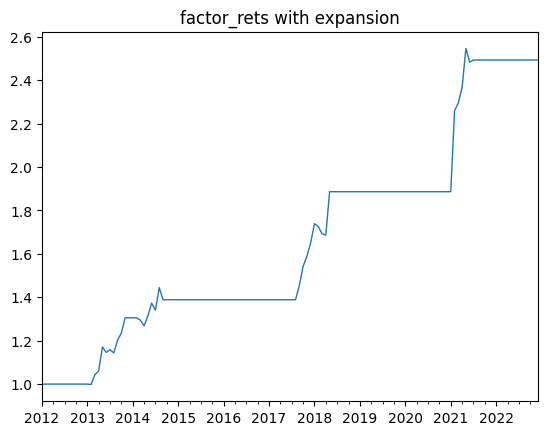

In [8]:
regime_df = business_cycle()
regime_df = regime_df.loc['2012-01':'2022-12']
regime_df.index = factor_daily_rets.resample('M').last().index

fr_df = factor_with_regime(regime_df, factor_cum_rets.resample('M').last().pct_change().fillna(0), 'factor_rets')#.dropna()
check_factor_with_regime(fr_df, 'factor_rets', 'month', plot=True)

### 시황별 성과 확인

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)


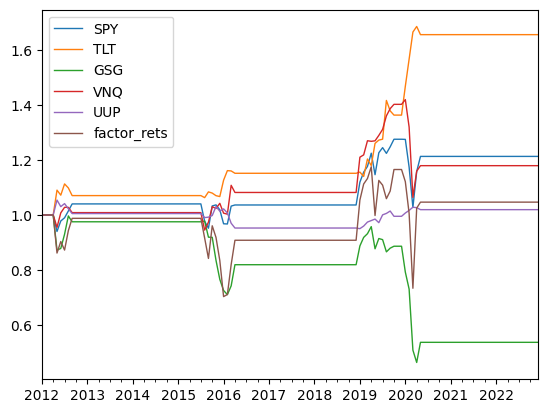

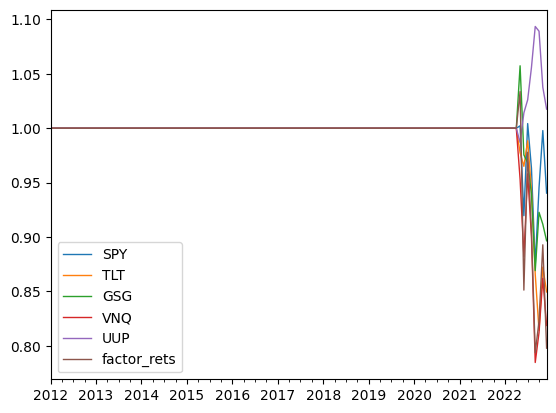

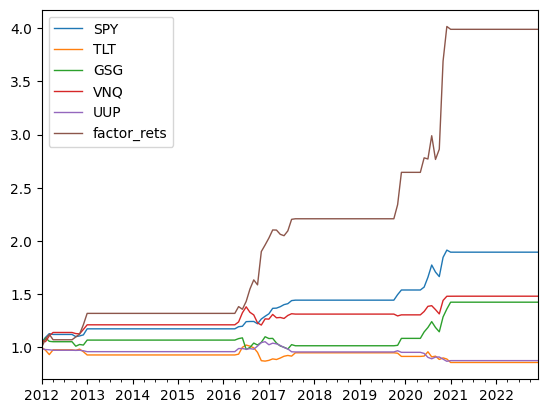

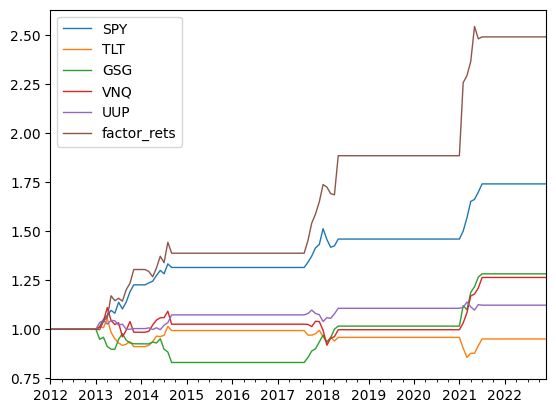

In [9]:
asset_ticker = ['SPY','TLT', 'GSG', 'VNQ', 'UUP']
asset_df = asset_indicators(asset_ticker)

ma_regime_df = multi_asset_df(asset_df, fr_df)
check_best_regime(ma_regime_df, 'month', _plot=True)

### 결과에 따라 투자해보자
- ma_regime_df.loc[(ma_regime_df.recovery == 1),'factor_rets'] = 1
- ma_regime_df.loc[(ma_regime_df.expansion == 1),'factor_rets'] = 1
- ma_regime_df.loc[(ma_regime_df.deflation == 1),'TLT'] = 1
- ma_regime_df.loc[(ma_regime_df.inflation == 1),'UUP'] = 1

In [10]:
indexes_df = asset_indicators()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [11]:
alternate_asset_list = ['SPY','TLT', 'GSG', 'VNQ', 'UUP']
invest_price = invest_asset_df(indexes_df, factor_cum_rets, alternate_asset_list)

rebal_list = rebal_dates(invest_price, period='month')
rebal_price_df = price_on_rebal(invest_price, rebal_list)

In [12]:
regime_asset_dict = {'recovery': 'factor_rets', 
                    'expansion': 'factor_rets', 
                    'deflation': 'TLT', 
                    'inflation': 'UUP'
                    }

In [13]:
regime_signal_df = regime_signal(ma_regime_df, regime_asset_dict)

regime_signal_df.to_csv('result/beta_regime_signal.csv')

In [14]:
regime_signal_df.sum(axis=1).sum()

132

In [15]:
regime_weight = Equalizer(signal=regime_signal_df, rebal_price=rebal_price_df, param=12).ew()
regime_weight = regime_weight.fillna(0)
regime_weight

,SPY,TLT,GSG,VNQ,UUP,factor_rets,CASH
2012-01-31,0,0.0,0,0,0.0,1.0,0.0
2012-02-29,0,0.0,0,0,0.0,1.0,0.0
2012-03-31,0,0.0,0,0,0.0,1.0,0.0
2012-04-30,0,0.0,0,0,0.0,1.0,0.0
2012-05-31,0,1.0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2022-08-31,0,0.0,0,0,1.0,0.0,0.0
2022-09-30,0,0.0,0,0,1.0,0.0,0.0
2022-10-31,0,0.0,0,0,1.0,0.0,0.0
2022-11-30,0,0.0,0,0,1.0,0.0,0.0


In [16]:
regime_port = calculate_portvals(price_df=invest_price, weight_df=regime_weight, signal_df=regime_signal_df, long_only=True)
daily = port_rets(regime_port, False)

daily.to_csv('result/beta_regime_daily.csv')

Total Returns: 1165.15%
CAGR: 26.06%
Annualized Volatility: 19.95%
Skewness: 0.62
Kurtosis: 11.51
Max Drawdown: -24.85%
Max Drawdown Duration: 322.00 days
Annualized Sharp Ratio: 1.11
Annualized Sortino Ratio: 1.95
Annualized Calmar Ratio: 1.05
Annualized VaR: -0.04
Annualized VaR Ratio: 0.03
Annualized CVaR: -0.04
Annualized CVaR Ratio: 0.02
Annualized hit Ratio: 0.66
Annualized GtP Ratio: 0.67


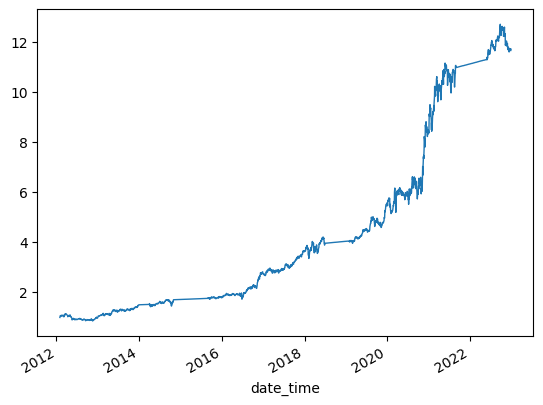

In [17]:
port_rets(regime_port, True).plot(lw=1)
Metric(portfolio=port_rets(regime_port, True)).print_report()